In [1]:
import numpy as np
import os
import open3d as o3d

import matplotlib.pyplot as plt
from scipy.stats import norm

wd = os.getcwd()
print("working directory", wd)
dataset_dir = wd + '/../../Datasets/sg27_station5_intensity_rgb.txt'
print(dataset_dir)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
working directory /home/aman/MikiMarkII/Thesis/point cloud
/home/aman/MikiMarkII/Thesis/point cloud/../../Datasets/sg27_station5_intensity_rgb.txt


pcd_combined = o3d.geometry.PointCloud()
pcd_combined.points = o3d.utility.Vector3dVector(pcd)
#o3d.visualization.draw_plotly([pcd_combined], point_sample_factor=0.2) # Draws in Notebook but looks bad
o3d.visualization.draw_geometries([pcd_combined]) # Draws in separate window but looks good

## Reading Point Cloud data

In [2]:
class point_cloud():
    def __init__(self):
        # Removing the intensity column from the dataset
        self.format = 3 # (x, y, z, r, g, b)

    def o3d_format(self, arr):
        pcd = np.zeros((np.shape(arr)[0], self.format))
        colors = np.zeros((np.shape(arr)[0], self.format))
        for i in range(self.format):
            pcd[:, i] = arr[:, i] 
            colors[:, i] = arr[:, i+4] * 0.00392156862   # Converting pixel values to float [0, 1]
        
        #print('pcd from o3d', np.shape(pcd))
        pcd_combined = o3d.geometry.PointCloud()
        pcd_combined.points = o3d.utility.Vector3dVector(pcd)
        #pcd_combined.colors = o3d.utility.Vector3dVector(colors)
        
        # Downsample Point cloud
        down_pcd = pcd_combined.voxel_down_sample(voxel_size = 0.03)
        return pcd_combined, down_pcd

In [3]:
point_cloud_data = np.loadtxt(dataset_dir)

pcd, pcd_down = point_cloud().o3d_format(point_cloud_data)

print("Display point cloud Data(xyzIRGB) shape:", np.shape(point_cloud_data))
#print('pcd from o3d', pcd)

# Visualising the point cloud

o3d.visualization.draw_geometries([pcd_down])


Display point cloud Data(xyzIRGB) shape: (218272134, 7)


In [4]:
print("Number of points in raw point cloud data:", np.shape(pcd.points))
print("\nNumber of points in down sampled point cloud:", np.shape(pcd_down.points))

Number of points in raw point cloud data: (218272134, 3)

Number of points in down sampled point cloud: (10433625, 3)


In [ ]:
# Determining the height axis
z_idx = int(np.argmin(np.var(np.asarray(pcd_down.points), axis = 0)))
print(f"the height axis is:{z_idx}")

In [ ]:
# Plotting the distributions of coordinates in x, y and z axis
x = np.asarray(pcd_down.points)[:, 0]
y = np.asarray(pcd_down.points)[:, 1]
z = np.asarray(pcd_down.points)[:, 2]

x_axis = np.linspace(0, np.shape(pcd_down.points)[0],np.shape(pcd_down.points)[0])
y_axis = np.linspace(0, np.shape(pcd_down.points)[0],np.shape(pcd_down.points)[0])
z_axis = np.linspace(0, np.shape(pcd_down.points)[0],np.shape(pcd_down.points)[0])

f,(ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize= (12, 12))
ax_1.plot(x_axis, np.asarray(pcd_down.points)[:, 0])
ax_2.plot(x_axis, np.asarray(pcd_down.points)[:, 1])
ax_3.plot(x_axis, np.asarray(pcd_down.points)[:, 2])


In [ ]:
var = np.var(np.asarray(pcd_down.points)[:, 2])
mean = np.mean(np.asarray(pcd_down.points)[:, 2])
std = np.std(np.asarray(pcd_down.points)[:, 2])

print(np.shape(norm.pdf(np.asarray(pcd_down.points)[:, 2], mean, std)))
print(f"mean = {mean} \nvariance = {var} \nstandard Deviation: {std}")

In [ ]:
z_max = np.max(z)
z_min = np.min(z)
z_ = z/z_max
print(z_max, z_min)
print(np.max(z_))

In [ ]:
# FFT on z data

Z = np.fft.fft(z_)
N = len(Z)
n = np.arange(N)
T = N

freq = n/T

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.stem(freq, np.abs(Z), 'b', \
    markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

plt.subplot(122)
plt.plot(z_axis, np.fft.ifft(Z), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Point Cloud Segmentation
We try to get rid of the planar features first(liked roads) so that we can work on finding clusters of the remaining objects like trees, cars, etc in the point cloud data.
Here we first try to segment plane surfaces by using segment_plane api in OPEN3D library and use ransac method which takes 3 points and run iterations to find planar surface

### Method 2: Estimating Normal
Estimate normals for small and large search radius and find the difference of normals to find the curvature property 

In [5]:
class Ground_Filter:
    def __init__(self, pcd, search_radius_small, search_radius_large, normal_threshold, method = 'difference_of_normals'):
        # Initializing Parameters of Difference of Normal class
        self.pcd_small = o3d.geometry.PointCloud()
        self.pcd_small.points = o3d.utility.Vector3dVector(np.asarray(pcd.points))  # estimating normals on small search radius

        self.pcd_large = o3d.geometry.PointCloud()
        self.pcd_large.points = o3d.utility.Vector3dVector(np.asarray(pcd.points))  # estimating normals on large search radius

        self.search_radius_small = search_radius_small
        self.search_radius_large = search_radius_large
        self.normal_threshold = normal_threshold
        self.method = method

    def unit_vector(self, vector):
        vec_uni = vector/np.linalg.norm(vector) 
        return vec_uni

    def get_indices(self, normal):
        entries = np.shape(normal)[0]
        self.vertical_vector = np.array([[0, 0, 1]])        # unit vector perpendicular to xy plane
        indices = []
        
        if self.method == 'difference_of_normals':
            for i in range(entries):
                if np.linalg.norm(normal[i]) <= self.normal_threshold:
                    indices.append(i)
        
        elif self.method == 'angle_between_normals':
            self.angles = []
            for i in range(entries):
                angle = np.arccos(np.dot(self.vertical_vector, normal[i]))
                self.angles.append(angle)
                angle_threshold = self.normal_threshold * np.pi/180
                if (angle <= np.pi/2 and angle >= angle_threshold):
                    indices.append(i)
                elif (angle > np.pi/2 and (np.pi - angle) >= angle_threshold):
                    indices.append(i)
        return indices 

    def difference_of_normals(self):
    
        #Estimate normals for small search radius
        self.pcd_small.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamRadius(radius = self.search_radius_small))
        Normals_radius_small = np.copy(np.asarray(self.pcd_small.normals))

        # Invalidate the normals obtained using search_radius_small
        #self.pcd_small.normals = o3d.utility.Vector3dVector(np.zeros((np.shape(Normals_radius_small)[0], 3)))

        # Estimate normal using search_radius_large
        self.pcd_large.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamRadius(radius = self.search_radius_large))
        Normals_radius_large = np.copy(np.asarray(self.pcd_large.normals))

        # Invalidate the normals obtained using search_radius_small
        #self.pcd_large.normals = o3d.utility.Vector3dVector(np.zeros((np.shape(Normals_radius_large)[0], 3)))

        don = np.zeros(np.shape(Normals_radius_large))
        for i in range(np.shape(don)[0]):
            don[i] = np.abs((self.unit_vector(Normals_radius_large[i]) - self.unit_vector(Normals_radius_small[i]))) * 0.5

        return don  

In [16]:
pcd_down_copy = o3d.geometry.PointCloud()
pcd_down_copy.points = o3d.utility.Vector3dVector(np.asarray(pcd_down.points))

ground = Ground_Filter(pcd_down_copy, 0.1, 1, 0.1, method = 'difference_of_normals')
don = ground.difference_of_normals()
indices = ground.get_indices(don)


4765410

In [8]:
pcd_down_test = o3d.geometry.PointCloud()
pcd_down_test = pcd_down.select_by_index(indices)
pcd_down_test.normals = o3d.utility.Vector3dVector(don)
o3d.visualization.draw_geometries([pcd_down_test])

In [17]:
don_mag = []
for i in range(np.shape(don)[0]):
    don_mag.append(np.linalg.norm(don[i]))

don_mag = np.asarray(don_mag)
max_mag = don_mag.max()

colors = plt.get_cmap("jet")(don_mag)
pcd_down.colors = o3d.utility.Vector3dVector(colors[:, :3])
pcd_down.normals = o3d.utility.Vector3dVector(don)
o3d.visualization.draw_geometries([pcd_down])


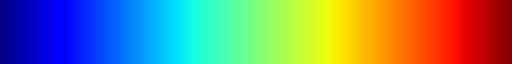

In [15]:
plt.get_cmap("jet")

In [9]:
pcd1 = pcd_down.select_by_index(indices)
pcd2 = pcd_down.select_by_index(indices, invert=True)
pcd1.paint_uniform_color([1, 0, 0])
pcd2.paint_uniform_color([0, 1, 0])
o3d.visualization.draw_geometries([pcd1])
o3d.visualization.draw_geometries([pcd2])

## RANSAC + DBSCAN Clustering

In [ ]:
# Segmentation on Raw point cloud data

plane_model_raw, inliers_raw = pcd.segment_plane(distance_threshold = 1, ransac_n = 3, num_iterations = 2000)

inlier_cloud_raw = pcd.select_by_index(inliers_raw)
inlier_cloud_raw.paint_uniform_color([1, 0, 0])

outlier_cloud_raw = pcd.select_by_index(inliers_raw, invert=True)
outlier_cloud_raw.paint_uniform_color([0.6, 0.6, 0.6])

In [ ]:
# Segmentation on downsampled point cloud data

plane_model_down_sampled, inliers_down_sampled = pcd_down.segment_plane(distance_threshold = 0.1, ransac_n = 10, num_iterations = 5000)

inlier_cloud_down_sampled = pcd_down.select_by_index(inliers_down_sampled)
inlier_cloud_down_sampled.paint_uniform_color([1, 0, 0])

outlier_cloud_down_sampled = pcd_down.select_by_index(inliers_down_sampled, invert=True)
outlier_cloud_down_sampled.paint_uniform_color([0.6, 0.6, 0.6])

In [ ]:
o3d.visualization.draw_geometries([inlier_cloud_down_sampled, outlier_cloud_down_sampled])

In [ ]:
o3d.visualization.draw_geometries([inlier_cloud_down_sampled])

In [ ]:
o3d.visualization.draw_geometries([outlier_cloud_down_sampled])

In [ ]:
# Implementing DBSCAN using open3d
#labels = np.array(outlier_cloud_down_sampled.cluster_dbscan(eps = 0.7, min_points = 7))
# clustering directly on raw point cloud data
labels = np.array(pcd_down.cluster_dbscan(eps = 0.7, min_points = 7))      
# eps = 0.05 means we use a radius of 5 cm for growing clusters and growing if we have atleast 10 points

max_label = labels.max()
colors = plt.get_cmap("tab20")(labels/(max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_down.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd_down])

In [ ]:
print(f"point cloud has {max_label + 1} clusters")

In [ ]:
np.min(pcd_down.compute_nearest_neighbor_distance())

In [ ]:
segment_models = {}
segments = {}

max_plane_id = 20

rest = pcd_new

In [ ]:
for i in range(max_plane_id):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers_segment = rest.segment_plane(distance_threshold = 0.1, ransac_n = 3, num_iterations=1000)
    segments[i] = rest.select_by_index(inliers_segment)

    segments[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers_segment, invert = True)
    print("pass", i, "/", max_plane_id, "done")

In [ ]:
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_id)] + [rest])

## Cloth Simulation Function

Turn the point cloud data upside down and put a cloth on it. Intersection points are the ground points. 


* The movement of a particle in the cloth is constrained to be in vertical direction, so the collision detection can be implemented by comparing the height values of the particle and the terrain(eg: when the position of the particle is **below or equal** to the terrain, the particle intersects with the terrain).

* When theparticle reaches the **"Right Position"**, i.e., the ground, this particle is set as unmovable.

* The forces are divided into two discrete steps to achieve simplicity and relatively high performance. Position of the particle is determined by the net force (External + internal). Here we compute the displacement due to gravity(the particle is set unmovable when it reaches the ground, so the collision force can be omitted) and then modify the position of this particle according to the internal forces

In [ ]:
# Invert the point cloud
R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])  # Finding image about xy plane
inverted_pcd = pcd_down.rotate(R)

# Get bounds on point cloud data(min-max x and y coordinates to get the xy plane)
x_min       = np.min(np.asarray(inverted_pcd.points)[:, 0])
x_max       = np.max(np.asarray(inverted_pcd.points)[:, 0])
y_min       = np.min(np.asarray(inverted_pcd.points)[:, 1])
y_max       = np.max(np.asarray(inverted_pcd.points)[:, 1])
z_initial   = np.min(np.asarray(inverted_pcd.points)[:, 2]) + 10  # Heigt from which the cloth will be droped

## Identifying Ground in Point cloud Data

1) Will try to make a ball of radius r at each point and check if there is a point below that, if not will collect those points otherwise move on to the next point. Will be doing this iteratively on all points. Will only check on those points which have not been identified, i.e., the points with min z value in the ball.
    - Issue here is if there is jsut a single point at that (x y) even though z is large, it will map it as a boundary point. So won't work
2) Another method would be getting surface normals and identifying the normal vectors that can form supporting planes to the point cloud data set
    - Only valid for convex set, as there may be some points that may not be able to separate , eg, crator


In [ ]:
# returns a list of indexs of points inside the ball
def Ball_r(arr, pcd, rad):
    x = arr[0]
    y = arr[1]
    z = arr[2]

    index = np.where()


In [ ]:

data_ground = []

for i in range(np.shape(pcd_down.points)[0]):
    if not data_ground or pcd_down.points[i] in data_ground:
        pass
    else:
        data_ground = pcd_down.points[Ball_r(pcd_down.points[i], pcd_down, 5)]

## Creating Triangular mesh from point cloud

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd_down, alpha = 1.5)
mesh.compute_vertex_normals()
o3d.visualization.draw([mesh])

## Convex Hull

In [ ]:
hull, _ = pcd_new.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw([pcd_new, hull_ls])

## Instance Segmentation